## Clustering and PCA on Chicago West Nile Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split
from sklearn import metrics

### Import data

In [2]:
path = '/Users/michaelshea/desktop/class/WestNile/WestNilePrediction/Assets/merged.csv'

In [3]:
merged = pd.read_csv(path)

In [4]:
merged['Date'] = pd.to_datetime(merged.Date)

In [5]:
merged.set_index('Date', inplace=True)

### Cluster with DBScan

Set columns for cluster analysis; limiting to a few for simplicity

In [95]:
cols_for_cluster = ['NumMosquitos', 'Month', 'Species_CULEX PIPIENS', 'Species_CULEX PIPIENS/RESTUANS', 
                   'Species_CULEX SALINARIUS', 'Species_CULEX TARSALIS', 'Tavg', 'PrecipTotal']

In [96]:
merged_cluster = merged[cols_for_cluster]

In [97]:
db = DBSCAN(eps=.5, min_samples=30)

In [98]:
db.fit(merged_cluster)

DBSCAN(algorithm='auto', eps=0.5, leaf_size=30, metric='euclidean',
    min_samples=30, p=None, random_state=None)

In [99]:
db.labels_

array([-1, -1, -1, ..., -1, -1, -1])

Add cluster labels as column to dataframe

In [100]:
merged['cluster'] = db.labels_

Group by clusters and observe any trends

In [101]:
grouped_cluster = merged.groupby('cluster').mean()

There are six clusters:

In [104]:
grouped_cluster.shape

(6, 29)

Plot clusters

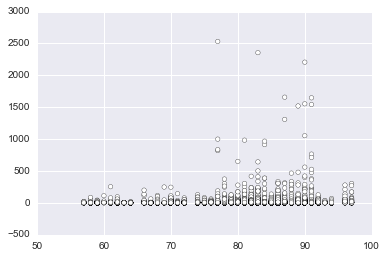

In [106]:
plt.scatter(merged.Tmax, merged.NumMosquitos, c=[merged.cluster])

### PCA

In [52]:
cols_for_pca = ['Tmax', 'Tmin', 'Tavg', 'DewPoint', 'WetBulb', 'Heat', 'Cool',
                'Sunrise', 'Sunset', 'PrecipTotal', 'ResultSpeed', 'AvgSpeed', 'Latitude', 'Longitude']

In [53]:
X = merged[cols_for_pca]

In [54]:
xStand = StandardScaler().fit_transform(X)

In [55]:
covMat = np.cov(xStand.T)
eigenValues, eigenVectors = np.linalg.eig(covMat)

In [56]:
eigenPairs = [(np.abs(eigenValues[i]), eigenVectors[:,i]) for i in range(len(eigenValues))]
eigenPairs.sort()
eigenPairs.reverse()
for i in eigenPairs:
    print(i[0])

6.17550197799
2.14083521053
1.74095375209
1.62309008034
0.977709423886
0.494208604263
0.362249231025
0.25287471384
0.108723819232
0.0867031339895
0.0317335348063
0.0060449387229
0.00102369163869
8.83639572391e-16


In [57]:
totalEigen = sum(eigenValues)
varExpl = [(i / totalEigen)*100 for i in sorted(eigenValues, reverse=True)]

In [58]:
print(varExpl)


[44.105523608471017, 15.289875747146569, 12.433916641565053, 11.59213260917881, 6.9828147138707273, 3.5296449325954513, 2.5871891982317803, 1.8060348293999891, 0.77650707473706426, 0.61923502522290774, 0.22664136025978321, 0.043173038969979434, 0.0073112203508598917, -6.3109664866754442e-15]


In [59]:
cvarex = np.cumsum(varExpl)

In [60]:
print(cvarex)

[ 44.10552361  59.39539936  71.829316    83.42144861  90.40426332
  93.93390825  96.52109745  98.32713228  99.10363936  99.72287438
  99.94951574  99.99268878 100.         100.        ]


90% of the variance is explained by the first five components.

In [61]:
pcask = PCA(n_components=5)
Y = pcask.fit_transform(xStand)

In [62]:
Ydf = pd.DataFrame(Y)

Conduct Logistic Regression with five principal components

In [63]:
logreg = LogisticRegression()

In [64]:
merged_2 = pd.read_csv(path)

In [65]:
X = Ydf
y = merged_2.WnvPresent

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [67]:
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [68]:
merged_2['Predictions'] = logreg.predict(X)

In [69]:
y_pred = logreg.predict(X)

In [70]:
print metrics.accuracy_score(y, y_pred)

0.946076696165


In [71]:
print metrics.confusion_matrix(y, y_pred)

[[8018    0]
 [ 457    0]]


In [72]:
print metrics.recall_score(y, y_pred)

0.0


Yikes, the logistic regression performed poorly -- 0 recall score

#### Conduct a Random Forest Classifier on PCA

In [73]:
from sklearn.cross_validation import train_test_split

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [75]:
rf = RandomForestClassifier()

In [76]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [77]:
y_pred = rf.predict(X_test)

In [78]:
metrics.recall_score(y_test, y_pred)

0.14035087719298245

In [79]:
metrics.precision_score(y_test, y_pred)

0.19753086419753085

In [80]:
metrics.accuracy_score(y_test, y_pred)

0.92307692307692313

In [81]:
metrics.confusion_matrix(y_test, y_pred)

array([[1940,   65],
       [  98,   16]])